# Import libraries and set up utils

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="9" #restrict CUDA visibility

import cv2
import numpy as np
import random
import math
from PIL import Image   # used to address load image
import torch
from matplotlib import pyplot as plt
import torch.nn.functional as F
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection
from diffusers import StableVideoDiffusionPipeline, AutoencoderKLTemporalDecoder, UNetSpatioTemporalConditionModel, EulerDiscreteScheduler
from diffusers.pipelines.stable_video_diffusion import StableVideoDiffusionPipelineOutput
from diffusers.models.unets.unet_spatio_temporal_condition import UNetSpatioTemporalConditionOutput
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.stable_video_diffusion.pipeline_stable_video_diffusion import _append_dims
from IPython.display import HTML

/opt/anaconda3/envs/sgi2v/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/sgi2v/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [2]:
"""
Define utils function
"""

def export_to_gif(
    video_frames, save_path
):
    """
    write to gif
    """
    if isinstance(video_frames[0], np.ndarray):
        video_frames = [(frame * 255).astype(np.uint8) for frame in video_frames]
    elif isinstance(video_frames[0], PIL.Image.Image):
        video_frames = [np.array(frame) for frame in video_frames]
    for i in range(len(video_frames)):
        video_frames[i] = Image.fromarray(video_frames[i])
    video_frames[0].save(save_path, save_all=True, append_images=video_frames[1:], loop=0, duration=110)
    return video_frames

def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag
def tensor2vid(video, processor, output_type: str = "np"):
    #ref: https://github.com/huggingface/diffusers/blob/687bc2772721af584d649129f8d2a28ca56a9ad8/src/diffusers/pipelines/stable_video_diffusion/pipeline_stable_video_diffusion.py#L61C1-L79C19
    batch_size, channels, num_frames, height, width = video.shape
    outputs = []
    for batch_idx in range(batch_size):
        batch_vid = video[batch_idx].permute(1, 0, 2, 3)
        batch_output = processor.postprocess(batch_vid, output_type)
        outputs.append(batch_output)
    if output_type == "np":
        outputs = np.stack(outputs)
    elif output_type == "pt":
        outputs = torch.stack(outputs)
    elif not output_type == "pil":
        raise ValueError(f"{output_type} does not exist. Please choose one of ['np', 'pt', 'pil]")    
    return outputs
def visualize_control(image, trajectory_points):
    scale_factor = 1.5
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(trajectory_points)):
        frames = len(trajectory_points[i])
        for j in range(frames):
            source_point = trajectory_points[i][j]
            sx, sy, tx, ty = source_point[0], source_point[1], source_point[2], source_point[3]
            if j==0:
                image2 = cv2.rectangle(image.copy(), (int(sy), int(sx)), (int(ty), int(tx)), (69, 27, 255), thickness=-1)
                image = cv2.rectangle(image, (int(sy), int(sx)), (int(ty), int(tx)), (0, 0, 255), thickness=6)
                image2 = cv2.rectangle(image2, (int(sy), int(sx)), (int(ty), int(tx)), (0, 0, 255), thickness=6)
                image = cv2.addWeighted(image,0.4,image2,0.6,0)
            if j + 1 < frames:
                target_point = trajectory_points[i][j+1]
                sx2, sy2, tx2, ty2 = target_point[0], target_point[1], target_point[2], target_point[3]
                sx3 = (sx+tx)//2
                tx3 = (sx2+tx2)//2
                sy3 = (sy+ty)//2
                ty3 = (sy2+ty2)//2
                arrow_length = np.sqrt((sx3-tx3)**2 + (sy3-ty3)**2)
                green = (0,255,0)
                if j + 2 == frames:
                    image = cv2.line(image, (int(sy3), int(sx3)), (int(ty3), int(tx3)), green, thickness = int(12*scale_factor))
                    image = cv2.circle(image, (int(ty3), int(tx3)), radius = int(15*scale_factor), color = green, thickness = -1)
                    #image = cv2.arrowedLine(image, (int(sy3), int(sx3)), (int(ty3), int(tx3)), green, 12, tipLength=2) #8/arrow_length)
                else:
                    image = cv2.line(image, (int(sy3), int(sx3)), (int(ty3), int(tx3)), green, thickness = int(12*scale_factor)) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
def butterworth_low_pass_filter(latents, n=4, d_s=0.25):
    """
    Return the butterworth low pass filter mask.
    Modified from https://github.com/arthur-qiu/FreeTraj/blob/0b3ffdb932bba01ba707d689f4905c31b193468b/utils/utils_freetraj.py#L228
    """
    shape = latents.shape
    H, W = shape[-2], shape[-1]
    mask = torch.zeros_like(latents)
    if d_s==0:
        return mask
    for h in range(H):
        for w in range(W):
            d_square = ((2*h/H-1)**2 + (2*w/W-1)**2)
            mask[..., h,w] = 1 / (1 + (d_square / d_s**2)**n)
    return mask

# Define denoising network

In [3]:
"""
Define denoising network (UNet)
"""

class MyUNet(UNetSpatioTemporalConditionModel):
    """
    Modified from SVD implementation
    https://github.com/huggingface/diffusers/blob/24c7d578baf6a8b79890101dd280278fff031d12/src/diffusers/models/unets/unet_spatio_temporal_condition.py#L32
    """
    def inject(self):
        #Replace self-attention blocks in the upsampling layers with our implementation
        for (layer, upsample_block) in enumerate(self.up_blocks):
            if layer == 0: 
                continue
            for (sublayer, trans) in enumerate(upsample_block.attentions):
                basictrans = trans.transformer_blocks[0] #BasicTransformerBlock
                basictrans.attn1.processor = self.my_self_attention(layer, sublayer)

    record_value_ = []
    
    def forward(
        self,
        sample,
        timestep,
        encoder_hidden_states,
        added_time_ids,
        return_dict: bool = True,
    ):
        #Modified from the original implementation such that it cuts redundant computation during the optimization
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            is_mps = False
            if isinstance(timestep, float):
                dtype = torch.float32 if is_mps else torch.float64
            else:
                dtype = torch.int32 if is_mps else torch.int64
            timesteps = torch.tensor([timesteps], dtype=dtype, device=sample.device)
        elif len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        batch_size, num_frames = sample.shape[:2]
        timesteps = timesteps.expand(batch_size)
        t_emb = self.time_proj(timesteps)
        t_emb = t_emb.to(dtype=sample.dtype)
        emb = self.time_embedding(t_emb)
        time_embeds = self.add_time_proj(added_time_ids.flatten())
        time_embeds = time_embeds.reshape((batch_size, -1))
        time_embeds = time_embeds.to(emb.dtype)
        aug_emb = self.add_embedding(time_embeds)
        emb = emb + aug_emb
        sample = sample.flatten(0, 1)
        emb = emb.repeat_interleave(num_frames, dim=0)
        encoder_hidden_states = encoder_hidden_states.repeat_interleave(num_frames, dim=0)
        sample = self.conv_in(sample)
        image_only_indicator = torch.zeros(batch_size, num_frames, dtype=sample.dtype, device=sample.device)
        down_block_res_samples = (sample,)
        for layer, downsample_block in enumerate(self.down_blocks):
            if hasattr(downsample_block, "has_cross_attention") and downsample_block.has_cross_attention:
                sample, res_samples = downsample_block(
                    hidden_states=sample,
                    temb=emb,
                    encoder_hidden_states=encoder_hidden_states,
                    image_only_indicator=image_only_indicator,
                )
            else:
                sample, res_samples = downsample_block(
                    hidden_states=sample,
                    temb=emb,
                    image_only_indicator=image_only_indicator,
                )

            down_block_res_samples += res_samples
        sample = self.mid_block(
            hidden_states=sample,
            temb=emb,
            encoder_hidden_states=encoder_hidden_states,
            image_only_indicator=image_only_indicator,
        )
        for i, upsample_block in enumerate(self.up_blocks):
            if self.training and i > max(self.record_layer_sublayer)[0]:
                return None #skip redundant computation during optimization
            res_samples = down_block_res_samples[-len(upsample_block.resnets) :]
            down_block_res_samples = down_block_res_samples[: -len(upsample_block.resnets)]
            if hasattr(upsample_block, "has_cross_attention") and upsample_block.has_cross_attention:
                sample = upsample_block(
                    hidden_states=sample,
                    temb=emb,
                    res_hidden_states_tuple=res_samples,
                    encoder_hidden_states=encoder_hidden_states,
                    image_only_indicator=image_only_indicator,
                )
            else:
                sample = upsample_block(
                    hidden_states=sample,
                    temb=emb,
                    res_hidden_states_tuple=res_samples,
                    image_only_indicator=image_only_indicator,
                )
        if self.training:
            return None #skip redundant computation during optimization
        sample = self.conv_norm_out(sample)
        sample = self.conv_act(sample)
        sample = self.conv_out(sample)
        sample = sample.reshape(batch_size, num_frames, *sample.shape[1:])
        if not return_dict:
            return (sample,)
        return UNetSpatioTemporalConditionOutput(sample=sample)
    
    def my_self_attention(self, layer, sublayer):
        compress_factor = [None, 4, 2, 1][layer]
        #Modified from the original implementation so that we can record semantically aligned feature maps during the optimization
        def processor(
            attn,
            hidden_states,
            encoder_hidden_states = None,
            attention_mask = None,
            temb = None,
        ):
            residual = hidden_states

            h = self.latent_shape[-2]//compress_factor
            w = self.latent_shape[-1]//compress_factor
            
            input_ndim = hidden_states.ndim
            batch_size, sequence_length, _ = (
                hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
            )
            query = attn.to_q(hidden_states)
            if encoder_hidden_states is None:
                encoder_hidden_states = hidden_states
            key = attn.to_k(encoder_hidden_states)
            value = attn.to_v(encoder_hidden_states)
            inner_dim = key.shape[-1]
            head_dim = inner_dim // attn.heads
            query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
            key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
            value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
            
            if self.training and ((layer, sublayer) in self.record_layer_sublayer):
                #Modified self-attention computation
                #inject key and value from the first frame to obtain semantically aligned fieature maps
                frame = query.shape[0]
                key2 = (key.reshape((1, frame)+key.shape[1:]))[:,:1].repeat((1,frame,1,1,1)).reshape(key.shape)
                value2 = (value.reshape((1, frame)+value.shape[1:]))[:,:1].repeat((1,frame,1,1,1)).reshape(value.shape)

                hidden_states = F.scaled_dot_product_attention(query, key2.clone().detach(), value2.clone().detach(), attn_mask=None, dropout_p=0.0, is_causal=False)
                hid = hidden_states.permute((0, 2, 1, 3)) #(2*batch, h*w, head, channel)
                hid = hid.reshape((hid.shape[0], h, w, -1))
                self.record_value_.append(hid)
            
            hidden_states = F.scaled_dot_product_attention(
                    query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
            )
            hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim)
            hidden_states = hidden_states.to(query.dtype)
            hidden_states = attn.to_out[0](hidden_states)
            hidden_states = attn.to_out[1](hidden_states)
            hidden_states = hidden_states / attn.rescale_output_factor
            return hidden_states
        return processor

# Define pipeline

In [4]:
"""
Define Pipeline
"""

class SGI2VPipe(StableVideoDiffusionPipeline):
    """
    Modified from the original SVD pipeline
    ref: https://github.com/huggingface/diffusers/blob/24c7d578baf6a8b79890101dd280278fff031d12/src/diffusers/pipelines/stable_video_diffusion/pipeline_stable_video_diffusion.py#L139
    """
    heatmap = {}
    def get_gaussian_heatmap(self, h, w):
        """
        Generate gaussian heatmap
        Modified from https://github.com/showlab/DragAnything/blob/main/demo.py#L380
        """
        if (h,w) in self.heatmap:
            isotropicGrayscaleImage = self.heatmap[(h,w)]
        else:
            sigy = self.unet.heatmap_sigma*(h/2)
            sigx = self.unet.heatmap_sigma*(w/2)

            cx = w/2
            cy = h/2
            isotropicGrayscaleImage = np.zeros((h, w), np.float32)
            for y in range(h):
                for x in range(w):
                    isotropicGrayscaleImage[y, x] = 1 / 2 / np.pi / (sigx*sigy) * np.exp(
                        -1 / 2 * ((x+0.5 - cx) ** 2 / (sigx ** 2) + (y+0.5 - cy) ** 2 / (sigy ** 2)))
            isotropicGrayscaleImage = (isotropicGrayscaleImage / np.max(isotropicGrayscaleImage)).astype(np.float32)
            self.heatmap[(h,w)] = isotropicGrayscaleImage
        return torch.from_numpy(isotropicGrayscaleImage).cuda()
    
    def optimize_latent(self, latents, trajectory_points, t, image_latents, image_embeddings, added_time_ids):
        """
        trajectory_points : N x frames x 4 (i.e. upper-left and bottom-right corners of bounding box : sx,sy,tx,ty)
        """
        original_latents = latents.clone().detach()
        
        if self.unet.optimize_latent_iter > 0: 
            self.unet = self.unet.to(dtype=torch.float32)
            self.unet.enable_gradient_checkpointing()
            self.unet.train(True)
            latents = latents.to(dtype=torch.float32)
            image_latents = image_latents.to(dtype=torch.float32)
            image_embeddings = image_embeddings.to(dtype=torch.float32)
            added_time_ids = added_time_ids.to(dtype=torch.float32)
            t = t.to(dtype=torch.float32)
            
            with torch.enable_grad():
                latents = latents.clone().detach().requires_grad_(True)        
                optimizer = None 
                scaler = torch.cuda.amp.GradScaler()
                target_features = [None]*len(trajectory_points)
                
                for iter in range(self.unet.optimize_latent_iter):
                    
                    latent_model_input = self.scheduler.scale_model_input(latents, t)
                    latent_model_input = torch.cat([latent_model_input, image_latents], dim=2)

                    self.unet.record_value_ = []
                    with torch.autocast(device_type = "cuda", dtype=torch.float16):
                        self.unet(latent_model_input,t,encoder_hidden_states=image_embeddings,added_time_ids=added_time_ids,return_dict=False)
                    
                    features = [] #list([frame, h, w, feature])

                    #Upsample recorded feature maps to the latent size
                    h, w = (self.unet.latent_shape[-2], self.unet.latent_shape[-1])
                    for i in range(len(self.unet.record_value_)):
                        fet = self.unet.record_value_[i].to(dtype=torch.float32).permute((0,3,1,2)) #[frame, feature, h, w]
                        fet = F.interpolate(fet, size=(h,w), mode="bilinear")
                        features.append(fet.permute((0,2,3,1)))

                    feature = torch.cat(features, dim=-1) #[frames, h, w, features]
                    
                    self.unet.record_value_ = []
                        
                    compress_factor = 8*self.unet.latent_shape[-2]//h
                        
                    frames = features[0].shape[0]
                        
                    loss = 0
                    loss_cnt = 0
                    
                    for j in range(frames):
                        #iterate over each control point
                        for point_idx in range(len(trajectory_points)):  
                            cur_point = (trajectory_points[point_idx][j]//compress_factor).astype(np.int32)
                            
                            sx, sy = cur_point[0], cur_point[1]
                            tx, ty = max(sx+1, cur_point[2]), max(sy+1, cur_point[3])
                            
                            #boundary check
                            sx_, sy_, tx_, ty_ = max(sx, 0), max(sy, 0), min(tx, feature.shape[1]), min(ty, feature.shape[2])
                            
                            #compute offset
                            osx, osy, otx, oty  = sx_ - sx, sy_ - sy, tx_ - sx, ty_ - sy

                            if sx_ >= tx_ or sy_ >= ty_:
                                #trajectory point goes beyond the image boundary
                                if j==0:
                                    print("Invalid trajectory, the initial boundaing box should not go beyond image boundary!!")
                                    exit(1)
                                continue
                            
                            if j == 0:
                                #Record feature maps of the first frame
                                target_features[point_idx] = feature[0,sx:tx,sy:ty].clone().detach().requires_grad_(False)
                            
                            #Compute loss
                            if j > 0:
                                    target = target_features[point_idx].unsqueeze(0) #[1, h, w, feature]
                                    target = F.interpolate(target.permute((0,3,1,2)),size=(tx-sx, ty-sy), mode="bilinear") #[1,feature,h,w]
                                    target = target.permute((0,2,3,1))[0] #[h, w, feature]
                                    target = target[osx:otx, osy:oty] #[h', w', feature]
                                    source = feature[j,sx_:tx_,sy_:ty_]
                                    
                                    #compute pixel-wise difference
                                    pixel_wise_loss = F.mse_loss(target, source, reduction="none").mean(dim=-1)
                                    
                                    #gaussian weight applied
                                    mask = self.get_gaussian_heatmap(tx-sx, ty-sy)
                                    mask = mask[osx:otx, osy:oty]
                                    assert(mask.shape == pixel_wise_loss.shape)

                                    #weight loss depending on the weight
                                    pixel_wise_loss = pixel_wise_loss
                                    
                                    #add up to the loss
                                    loss = loss + (mask*pixel_wise_loss).sum()
                                    loss_cnt += mask.sum()
                        
                    loss = loss/max(1e-8, loss_cnt)
                    
                    if optimizer == None:
                        #Initialize optimizer
                        optimizer = torch.optim.AdamW([latents], lr = self.unet.optimize_latent_lr) 
                    
                    self.unet.zero_grad()
                    optimizer.zero_grad()
                    if loss_cnt > 0:
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                    del loss
                    del feature
                    del self.unet.record_value_
                    torch.cuda.empty_cache()

                    if loss_cnt==0:
                        break #nothing to optimize
            
            if self.unet.latent_fft_post_merge:
                fft_axis = (-2, -1) #H and W
                with torch.no_grad():
                    #latents: [1, frames = 14, channel = 4, h, w]               
                    #create low pass filter
                    LPF = butterworth_low_pass_filter(latents, d_s = self.unet.latent_fft_ratio)
                    
                    #FFT
                    latents_freq = torch.fft.fftn(latents, dim=fft_axis)
                    latents_freq = torch.fft.fftshift(latents_freq, dim=fft_axis)
                    original_latents_freq = torch.fft.fftn(original_latents.to(dtype=torch.float32), dim=fft_axis)
                    original_latents_freq = torch.fft.fftshift(original_latents_freq, dim=fft_axis)
        
                    #frequency mix
                    HPF = 1 - LPF
                    new_freq = latents_freq*LPF + original_latents_freq*HPF
        
                    #IFFT
                    new_freq = torch.fft.ifftshift(new_freq, dim=fft_axis)
                    latents = torch.fft.ifftn(new_freq, dim=fft_axis).real
            
            self.unet = self.unet.to(dtype=torch.float16)
            latents = latents.to(dtype=torch.float16)
            image_latents = image_latents.to(dtype=torch.float16)
            image_embeddings = image_embeddings.to(dtype=torch.float16)
            added_time_ids = added_time_ids.to(dtype=torch.float16)
            t = t.to(dtype=torch.float16)
            self.unet.train(False)
        
        latents = latents.detach().requires_grad_(False)
        return latents
    
    def __call__(self, image, trajectory_points, height, width, num_frames, min_guidance_scale = 1.0, max_guidance_scale = 3.0, fps = 7,
                 generator = None, motion_bucket_id = 127, noise_aug_strength = 0.02, decode_chunk_size = 8):
        #Modified from the original implementaion such that the pipeline incorporates our latent optimization procedure
        batch_size = 1
        fps = fps - 1
        self._guidance_scale = max_guidance_scale
        image_embeddings = self._encode_image(image, "cuda", 1, self.do_classifier_free_guidance)
        try: 
            image = self.image_processor.preprocess(image, height=height, width=width).to("cuda")
        except:
            self.image_processor = self.video_processor 
            image = self.image_processor.preprocess(image, height=height, width=width).to("cuda")
        noise = randn_tensor(image.shape, generator=generator, device=image.device, dtype=image.dtype).to("cuda")
        image = image + noise_aug_strength * noise
        needs_upcasting = self.vae.dtype == torch.float16 and self.vae.config.force_upcast
        if needs_upcasting:
            self.vae.to(dtype=torch.float32)
        image_latents = self._encode_vae_image(
            image,
            device="cuda",
            num_videos_per_prompt=1,
            do_classifier_free_guidance=self.do_classifier_free_guidance,
        )
        image_latents = image_latents.to(image_embeddings.dtype)
        if needs_upcasting:
            self.vae.to(dtype=torch.float16)
        image_latents = image_latents.unsqueeze(1).repeat(1, num_frames, 1, 1, 1)
        added_time_ids = self._get_add_time_ids(
            fps,
            motion_bucket_id,
            noise_aug_strength,
            image_embeddings.dtype,
            batch_size,
            1,
            self.do_classifier_free_guidance,
        )
        added_time_ids = added_time_ids.to("cuda")
        self.scheduler.set_timesteps(self.unet.num_inference_steps, device="cuda")
        timesteps = self.scheduler.timesteps
        num_channels_latents = self.unet.config.in_channels
        shape = (
            batch_size,
            num_frames,
            num_channels_latents // 2,
            height // self.vae_scale_factor,
            width // self.vae_scale_factor,
        )
        latents = randn_tensor(shape, generator=generator, device=image.device, dtype=image_embeddings.dtype).to("cuda")
        latents = latents * self.scheduler.init_noise_sigma # scale the initial noise by the standard deviation required by the scheduler
        self.unet.latent_shape = latents.shape
        guidance_scale = torch.linspace(min_guidance_scale, max_guidance_scale, num_frames).unsqueeze(0)
        guidance_scale = guidance_scale.to("cuda", latents.dtype)
        guidance_scale = guidance_scale.repeat(batch_size, 1)
        guidance_scale = _append_dims(guidance_scale, latents.ndim)
        self._guidance_scale = guidance_scale

        #Free cuda memory
        self.vae = self.vae.to("cpu")
        self.image_encoder = self.image_encoder.to("cpu")
        torch.cuda.empty_cache()
            
        #Denoising loop
        num_warmup_steps = len(timesteps) - self.unet.num_inference_steps * self.scheduler.order #num_warmup_steps = 0 in our setting
        self._num_timesteps = len(timesteps)
        with self.progress_bar(total=self.unet.num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                self.unet.cur_timestep = len(timesteps) - i
                
                if (self.unet.cur_timestep in self.unet.optimize_latent_time):
                    #update latent through optimization
                    latents = self.optimize_latent(latents, trajectory_points, t, image_latents[1:], image_embeddings[1:], added_time_ids[1:])
                
                latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
                latent_model_input = torch.cat([latent_model_input, image_latents], dim=2)
                with torch.no_grad():
                    noise_pred = self.unet(
                        latent_model_input,
                        t,
                        encoder_hidden_states=image_embeddings,
                        added_time_ids=added_time_ids,
                        return_dict=False,
                    )[0]
                if self.do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_cond - noise_pred_uncond)
                latents = self.scheduler.step(noise_pred, t, latents,  s_churn = 0.0).prev_sample
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
        self.vae = self.vae.to("cuda")
        self.image_encoder = self.image_encoder.to("cuda")
        if needs_upcasting:
            self.vae.to(dtype=torch.float16)
        frames = self.decode_latents(latents, num_frames, decode_chunk_size)
        frames = tensor2vid(frames, self.image_processor, output_type="np")
        self.maybe_free_model_hooks()
        return StableVideoDiffusionPipelineOutput(frames=frames)

# Set up config

In [5]:
class Config:
    """
    Hyperparameters
    """
    seed = 817
    height, width = 576, 1024 #resolution of generated video
    num_frames = 14
    num_inference_steps = 50 #total number of inference steps
    optimize_latent_time = list(range(30,46)) #set of timesteps to perform optimization
    optimize_latent_iter = 5 #number of optimization iterations to perform for each timestep
    optimize_latent_lr = 0.21 #learning rate for optimization
    record_layer_sublayer = [(2, 1), (2, 2)] #extract feature maps from 1st and 2nd self-attention (note: 0-indexed base) located at 2nd resolution-level of upsampling layer
    heatmap_sigma = 0.4 #standard deviation of gaussian heatmap
    fft_ratio = 0.5 #fft mix ratio
    latent_fft_post_merge = True #fft-based post-processing is enabled iff True

config = Config()


# Load pre-trained image-to-video diffusion models

In [6]:
# Load and set up the pipeline
svd_dir = "stabilityai/stable-video-diffusion-img2vid"
cache_dir = "./../"
    
feature_extractor = CLIPImageProcessor.from_pretrained(svd_dir, subfolder="feature_extractor", cache_dir=cache_dir, torch_dtype=torch.float16, variant="fp16")
vae = AutoencoderKLTemporalDecoder.from_pretrained(svd_dir, subfolder="vae", cache_dir=cache_dir, torch_dtype=torch.float16, variant="fp16").to("cuda")
requires_grad(vae, False)
image_encoder = CLIPVisionModelWithProjection.from_pretrained(svd_dir, subfolder="image_encoder", cache_dir = cache_dir, torch_dtype=torch.float16, variant="fp16").to("cuda")
requires_grad(image_encoder, False)
unet = MyUNet.from_pretrained(svd_dir, subfolder="unet", cache_dir=cache_dir, torch_dtype=torch.float16, variant="fp16").to("cuda")
requires_grad(unet, False)
scheduler = EulerDiscreteScheduler.from_pretrained(svd_dir, subfolder="scheduler", cache_dir=cache_dir, torch_dtype=torch.float16, variant="fp16")
        
unet.inject() #inject module
    
#Set up pipeline
pipe = SGI2VPipe(vae,image_encoder,unet,scheduler,feature_extractor).to(device="cuda")

AssertionError: Torch not compiled with CUDA enabled

# Prepare input

In [7]:
#Input example 1
"""
bounding_box : N x (w_1, h_1, w_2, h_2), specifying corner coordinates of bounding boxes on the first frame
center_traj: N x F x 2, specifying center coordinates (w, h) of bounding boxes at each frame
"""
image_url = "./examples/111/img.png"
bounding_box = [[404., 305., 773., 500.], [290.,   4., 541.,  74.]] 
center_traj = [
       [[588.        , 402.        ],
        [588.        , 402.        ],
        [588.        , 402.        ],
        [588.        , 402.        ],
        [588.        , 402.        ],
        [588.        , 402.        ],
        [588.        , 402.        ],
        [588.        , 402.        ],
        [588.        , 402.        ],
        [588.        , 402.        ],
        [588.        , 402.        ],
        [588.        , 402.        ],
        [588.        , 402.        ],
        [588.        , 402.        ]],

       [[415.        ,  39.        ],
        [453.5430132 ,  34.66408739],
        [486.12517069,  31.64997724],
        [512.56076468,  29.71734183],
        [532.66408739,  28.62585344],
        [546.24943104,  28.13518434],
        [553.13108785,  28.00500683],
        [553.32453345,  28.2553482 ],
        [547.85116067,  30.20801092],
        [536.72644515,  33.8830223 ],
        [519.76467911,  39.04005462],
        [496.78015476,  45.43878015],
        [467.58716431,  52.83887119],
        [432.        ,  61.        ]]]
assert(len(bounding_box)==len(center_traj))

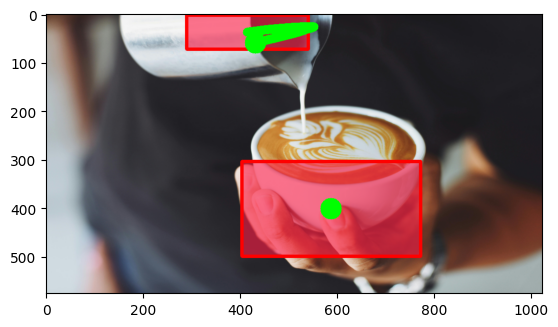

In [8]:
#load image
image = Image.open(image_url).convert('RGB')
image = image.resize((config.width, config.height))

#preprocess trajectory
bounding_box = np.array(bounding_box).astype(np.float32)
center_traj = np.array(center_traj).astype(np.float32)
trajectory_points = [] # N x frames x 4
for j, trajectory in enumerate(center_traj):
        #For normal use
        box_traj = [] # frames x 4
        for i in range(config.num_frames):
            d = center_traj[j][i] - center_traj[j][0]
            dx, dy = d[0], d[1]
            box_traj.append(np.array([bounding_box[j][1] + dy, bounding_box[j][0] + dx, bounding_box[j][3] + dy, bounding_box[j][2] + dx], dtype=np.float32))
        trajectory_points.append(box_traj)

#visualize
visualize_control(image, trajectory_points=trajectory_points)

# Generate video 

In [9]:
#Approx. 4 minutes on A6000 with default config
def run(config, image, trajectory_points, save_path):
    """
    Set up hyperparameters
    """
    pipe.unet.num_inference_steps = config.num_inference_steps
    pipe.unet.optimize_zero_initialize_param = True
    height, width = config.height, config.width
    motion_bucket_id = 127
    fps = 7
    num_frames = config.num_frames
    seed = config.seed
    pipe.unet.heatmap_sigma = config.heatmap_sigma
    pipe.unet.latent_fft_post_merge = config.latent_fft_post_merge
    pipe.unet.latent_fft_ratio = config.fft_ratio #range : 0.0 - 1.0
    pipe.unet.optimize_latent_iter = config.optimize_latent_iter
    pipe.unet.optimize_latent_lr = config.optimize_latent_lr
    pipe.unet.optimize_latent_time = config.optimize_latent_time
    pipe.unet.record_layer_sublayer =  config.record_layer_sublayer
    generator = torch.manual_seed(seed)
    frames = pipe(image, trajectory_points, height=height, width=width, num_frames = num_frames, decode_chunk_size=8, generator=generator, fps=fps, motion_bucket_id=motion_bucket_id, noise_aug_strength=0.02).frames[0]
    #save video
    export_to_gif(frames, save_path)

#generate video
run(config, image, trajectory_points, save_path="./result.gif")
HTML("<img src=\"" + "./result.gif" + "\">")

/scratch/ondemand28/namekata/conda_env/ex5/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969118/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
100%|███████████████████████████| 50/50 [04:19<00:00,  5.19s/it]
